In [50]:
import networkx as nx
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score

import numpy as np
import pandas as pd
from datetime import datetime

from collections import Counter
import itertools

from math import comb, ceil
from scipy import stats
import random
import string

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from tqdm import tqdm

import multiprocessing as mp

import pickle

import sys
sys.path.insert(1, '../scripts')
import modeling_v3

import importlib
importlib.reload(modeling_v3)

import matplotlib.ticker as plticker
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 14

In [51]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
def network_out_of_relationships(rel):
    g = nx.Graph()

    for p1, v in rel.items():
        g.add_node(p1)
        for p2, s in v.items():
            if s!=0:
                g.add_edge(p1,p2)

    return g

In [53]:
def connected_components(rel):
    g = network_out_of_relationships(rel)
    
    return [len(cc) for cc in nx.connected_components(g)]

In [54]:
def centrality_and_cc(rel):
    g = network_out_of_relationships(rel)
    
    degrees = nx.degree(g)
    degrees = dict(degrees)

    return degrees['A'], len(g.edges()), [len(cc) for cc in nx.connected_components(g)], nx.pagerank(g)

In [55]:
def one_agent_simulation(random_seed = 89, n_beliefs = 6, m = 15, gamma = .6, n_agents = 1, last_step = 10000, sigma = 1):
    
    np.random.seed(random_seed)
    random.seed(random_seed)

    # initialize the belief network
    bn = modeling_v3.create_belief_network(m = m,
                                            n_beliefs = n_beliefs,
                                            complete = True)

    # initialize the agent
    agent = modeling_v3.init_agents(bn, n_agents)[0]

    propositions = [*bn.nodes()]
    agent_list = [*agent.keys()]

    possible_propositions = [f"+{p}" for p in propositions] + [f"-{p}" for p in propositions]
    possible_messages = [{'e1':m[0],'e2':m[1]} for m in itertools.combinations(possible_propositions, 2) if m[0][1] != m[1][1]]
    index = [*range(len(possible_messages))]

    simulation_steps = [*range(last_step+1)]
    track = {}

    for t in tqdm(simulation_steps):

        # choose a message at random to convey
        message_to_convey = possible_messages[np.random.choice(index)]
        #print(message_to_convey)

        # update the agent's association matrix accordingly
        modeling_v3.update_association_matrix(message_to_convey, agent['association_matrix']) # update receiver's association matrix
        
        # assess the relationships and likelihoods of two propositions being exhibited together
        relationships, likelihoods = modeling_v3.determine_relationships_likelihoods(agent['association_matrix'], gamma)

        # update agent's belief randomly
        beliefs_new = modeling_v3.update_belief(message_to_convey['e1'], agent['beliefs'], sigma)
        
        # extract the relationship
        b1, b2 = message_to_convey['e1'][1], message_to_convey['e2'][1]
        relationship = relationships[b1][b2]

        if relationship != 0:

            energy_t = modeling_v3.energy(message_to_convey = message_to_convey,
                            beliefs = agent['beliefs'],
                            relationship = relationship)
            
            energy_t_plus_1 = modeling_v3.energy(message_to_convey = message_to_convey,
                            beliefs = beliefs_new,
                            relationship = relationship)

            if energy_t_plus_1 < energy_t:
                agent['beliefs'] = beliefs_new
        
        if t % 50 == 0:
            track[t] = {}
            track[t]['beliefs'] = agent['beliefs'].copy()
            
            cc = connected_components(relationships)
            track[t]['connected_components'] = cc

    return track

In [5]:
n_beliefs = 6
repetition = 32
m = 15
n_agents = 1
last_step = 10000
gamma = 0
sigma_vals = [.1, .3, .5, 1]

track = {}

for sigma in sigma_vals:
    random_states = [np.random.randint(0, 10000000) for i in range(repetition)]    

    params = [*zip(random_states,
                    [n_beliefs] * repetition, 
                    [m] * repetition,
                    [gamma] * repetition,
                    [n_agents] * repetition,
                    [last_step] * repetition,
                    [sigma] * repetition)]

    pool = mp.Pool(processes=32)
    temp = pool.starmap(one_agent_simulation, params, chunksize=1)
    pool.close()

    track[sigma] = temp
    del temp

100%|██████████| 10001/10001 [00:29<00:00, 335.73it/s]

100%|██████████| 10001/10001 [00:30<00:00, 333.30it/s]

100%|██████████| 10001/10001 [00:30<00:00, 327.05it/s]


# Analysis on the Effect of Sigma Value

In [12]:
propositions = [*track[.1][0][0]['beliefs'].keys()]

In [13]:
change_of_heart = {}
for sigma in sigma_vals:
    _ = []
    for experiment in [*range(32)]:
        change_per_experiment = 0
        for p in propositions:
            temp = track[sigma][experiment]
            change_per_experiment += (sum([np.sign(b)!=np.sign(a) for b,a in zip([v['beliefs'][p] for v in temp.values()][:-1], [v['beliefs'][p] for v in temp.values()][1:])]))
        _.append(change_per_experiment)
    change_of_heart[sigma] = _

Transform the analysis data into a dataframe so that it could be used with Seaborn

In [14]:
change_of_heart_df = []

for sigma, v in change_of_heart.items():
    for _ in v:
        change_of_heart_df.append((sigma, _))

change_of_heart_df = pd.DataFrame(change_of_heart_df, columns=['Sigma', 'Change of Heart'])

In [15]:
change_of_heart_df.pivot_table(index='Sigma', values='Change of Heart')

,Change of Heart
Sigma,
0.1,53.31250
0.3,221.50000
0.5,444.09375
1.0,886.78125


Text(0.5, 0, 'σ')

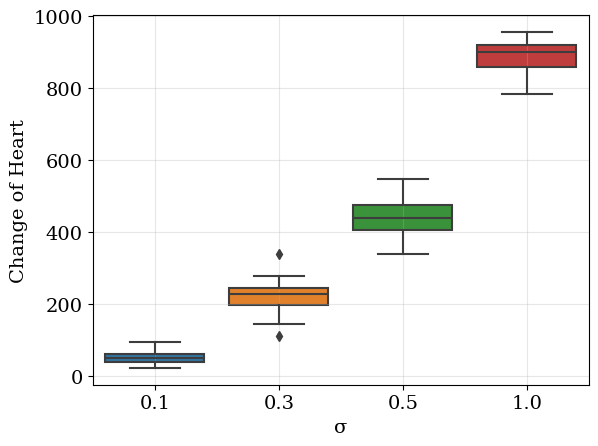

In [16]:
sns.boxplot(data=change_of_heart_df, x = 'Sigma', y = 'Change of Heart')
plt.grid(alpha=.3)
plt.xlabel('σ')

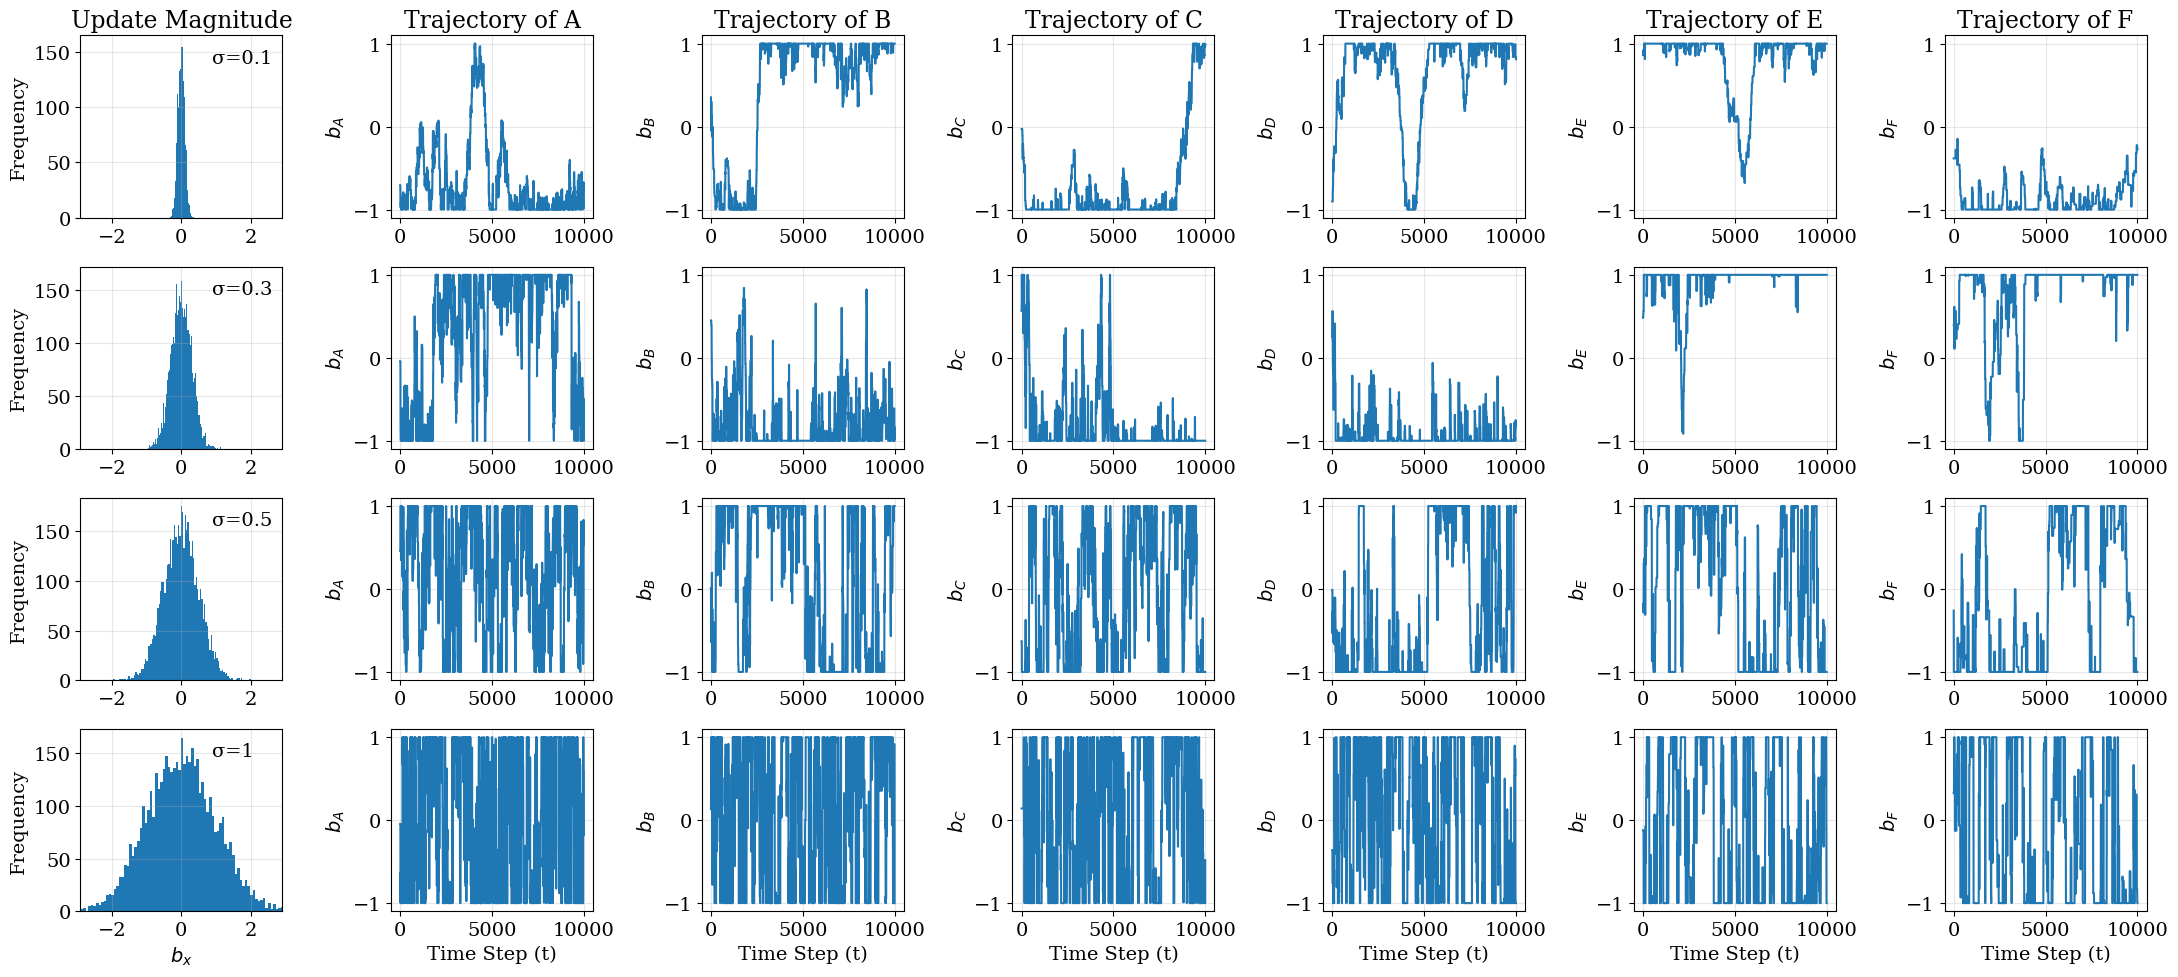

In [17]:
fig, axs = plt.subplots(4,7,figsize=(22,10))

cols = [*range(1, len(propositions)+1)]
rows = [0,1,2,3]

for row, sigma in zip(rows, sigma_vals):
        temp = track[sigma][10]

        for col, p in zip(cols, propositions):
                axs[row][col].plot(temp.keys(),
                                [v['beliefs'][p] for v in temp.values()])
                axs[row][col].set_ylim(-1.1, 1.1)
                axs[row][col].grid(alpha=.3)

                axs[row][col].set_ylim(-1.1, 1.1)
                axs[row][col].set_ylabel(f'$b_{p}$')

for col, p, in zip(cols, propositions):
        axs[0][col].set_title(f"Trajectory of {p}")
        axs[3][col].set_xlabel('Time Step (t)')


for row, sigma in zip(rows, sigma_vals):
        axs[row][0].hist(np.random.normal(0, sigma, 5000), bins=100)
        axs[row][0].set_xlim(-2.9,2.9)
        axs[row][0].text(.65, .85, s=f'σ={sigma}', transform = axs[row][0].transAxes)
        axs[row][0].grid(alpha=.3)
        axs[row][0].set_ylabel('Frequency')

axs[0][0].set_title('Update Magnitude')
axs[row][0].set_xlabel('$b_x$')

fig.tight_layout()
fig.savefig('../figures/sigma_analysis.pdf')

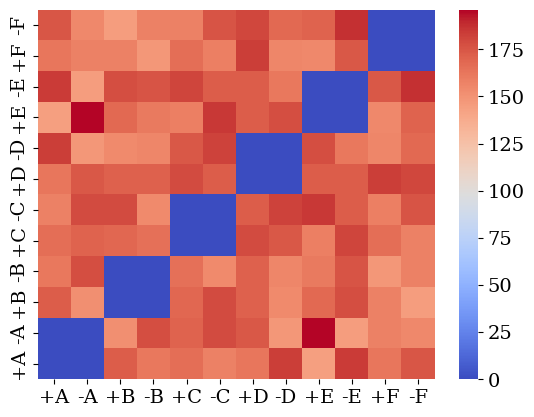

In [54]:
hmap = sns.heatmap(agent['association_matrix'], cmap='coolwarm')
hmap.invert_yaxis()

# Analysis of the Gamma Value

In [25]:
n_beliefs = 6
repetition = 64
m = 15
n_agents = 1
last_step = 10000
gamma_vals = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
sigma = .3

track = {}

for gamma in gamma_vals:
    random_states = [np.random.randint(0, 10000000) for i in range(repetition)]    

    params = [*zip(random_states,
                    [n_beliefs] * repetition, 
                    [m] * repetition,
                    [gamma] * repetition,
                    [n_agents] * repetition,
                    [last_step] * repetition,
                    [sigma] * repetition)]

    pool = mp.Pool(processes=32)
    temp = pool.starmap(one_agent_simulation, params, chunksize=1)
    pool.close()

    track[gamma] = temp
    del temp

100%|██████████| 10001/10001 [00:32<00:00, 284.12it/s]

100%|██████████| 10001/10001 [00:33<00:00, 300.71it/s]

100%|██████████| 10001/10001 [00:32<00:00, 306.93it/s]

100%|██████████| 10001/10001 [00:33<00:00, 297.72it/s]

 99%|█████████▉| 9935/10001 [00:32<00:00, 314.39it/s]]

  2%|▏         | 154/10001 [00:00<00:33, 294.59it/s]]]

 99%|█████████▉| 9882/10001 [00:33<00:00, 309.50it/s]]

100%|██████████| 10001/10001 [00:33<00:00, 299.30it/s]

100%|██████████| 10001/10001 [00:33<00:00, 297.29it/s]

 99%|█████████▉| 9883/10001 [00:32<00:00, 304.98it/s]]

  1%|          | 62/10001 [00:00<00:32, 304.12it/s]/s]

100%|██████████| 10001/10001 [00:33<00:00, 295.68it/s]

100%|██████████| 10001/10001 [00:33<00:00, 295.96it/s]

 99%|█████████▉| 9882/10001 [00:33<00:00, 308.44it/s]]

100%|█████████▉| 9951/10001 [00:33<00:00, 301.65it/s]]

100%|██████████| 10001/10001 [00:35<00:00, 280.52it/s]


In [26]:
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
with open(f'../data/results_one_agent_{dt_string}.pkl', 'wb') as f:
    pickle.dump(track, f)

In [30]:
cc_df = pd.DataFrame({gamma: [len(sim[10000]['connected_components']) for sim in v] for gamma, v in track.items()})

The histogram for the average number of connected components throughout each simulation

In [126]:
cc_df_2 = []
for gamma in gamma_vals:
    for v in [np.mean([len(v['connected_components']) for v in t.values()]) for t in track[gamma]]:
        cc_df_2.append((gamma,v))

cc_df_2 = pd.DataFrame(cc_df_2, columns=['Gamma','Avg. Number of Connected Components'])

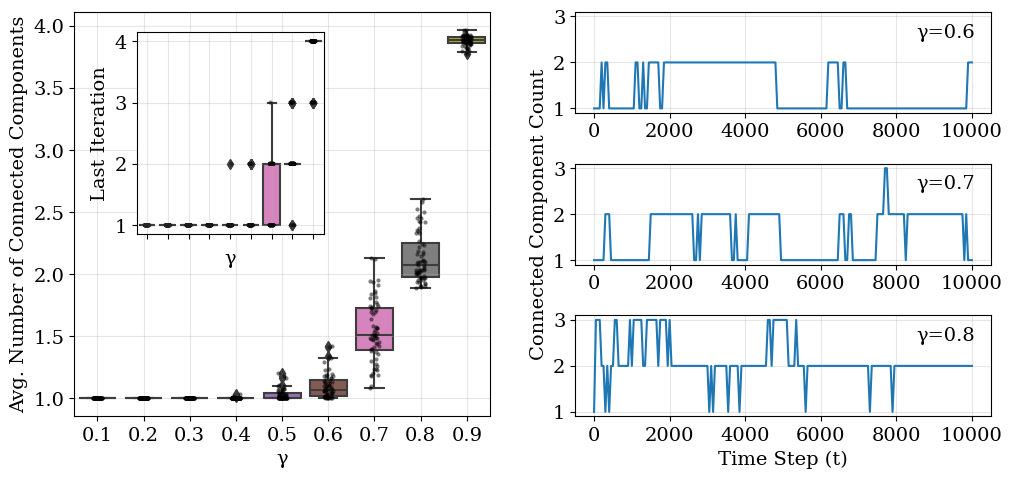

In [329]:
gs = gridspec.GridSpec(3, 3, width_ratios=[1, 10, 10], height_ratios=[1, 1, 1])

fig = plt.figure(figsize=(11, 5))

# Define the subplots
ax1 = fig.add_subplot(gs[:, 1])  # spans all rows, first column
ax2 = fig.add_subplot(gs[0, 2])  # first row, third column
ax3 = fig.add_subplot(gs[1, 2])
ax4 = fig.add_subplot(gs[2, 2])

sns.boxplot(cc_df_2, y='Avg. Number of Connected Components', x = 'Gamma', ax=ax1)
sns.stripplot(cc_df_2, y='Avg. Number of Connected Components', x = 'Gamma', ax=ax1, color='black', size=3, alpha=.5)

ins = ax1.inset_axes([0.15,0.45,0.45,0.5])
sns.boxplot(cc_df, ax=ins)
sns.stripplot(cc_df, ax=ins, color='black', size=3, alpha=.5)
ins.set_xticklabels([])

for ax, gamma, sim in zip([ax2,ax3,ax4], [.6,.7,.8], [21,16,16]):
    ax.plot([t*50 for t in range(len([len(v['connected_components']) for v in track[gamma][sim].values()]))],
            [len(v['connected_components']) for v in track[gamma][sim].values()])
    ax.grid(alpha=.3)
    ax.set_ylim(0.9,3.1)
    ax.text(.82, .75, s=f'γ={gamma}', transform = ax.transAxes)


xlabels = ['γ','γ', '', '', 'Time Step (t)']
ylabels = ['Avg. Number of Connected Components', 'Last Iteration', '', '', '']

for ax, xlabel, ylabel in zip([ax1,ins,ax2,ax3,ax4], xlabels, ylabels):
    ax.grid(alpha=.3)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

ax3.set_ylabel('Connected Component Count')

fig.tight_layout()
fig.savefig('../figures/gamma_analysis.pdf')
fig.show()

# **Feeding the Agent with Biased Information**

In [7]:
def one_agent_simulation_biased_info(random_seed = 89, n_beliefs = 6, m = 15, gamma = .8, n_agents = 1, last_step = 10000, sigma = 1, times_more_likely = 1):
    
    np.random.seed(random_seed)
    random.seed(random_seed)

    # initialize the belief network
    bn = modeling_v3.create_belief_network(m = m,
                                            n_beliefs = n_beliefs,
                                            complete = True)

    # initialize the agent
    agent = modeling_v3.init_agents(bn, n_agents)[0]

    propositions = [*bn.nodes()]
    agent_list = [*agent.keys()]

    ratios = np.array([times_more_likely] + [1]*5)
    probs = ratios/sum(ratios)

    simulation_steps = [*range(last_step+1)]
    track = {}

    for t in simulation_steps:

        # choose a message with biased probabilities to convey
        p1 = np.random.choice(propositions, 1, p=probs)[0]

        temp = propositions.copy()
        temp.remove(p1)
        p2 = np.random.choice(temp, 1)[0]

        s1 = np.random.choice(['-', '+'])
        s2 = np.random.choice(['-', '+'])

        message_to_convey = {'e1':f"{s1}{p1}", 'e2':f"{s2}{p2}"}
        #print(message_to_convey)

        # update the agent's association matrix accordingly
        modeling_v3.update_association_matrix(message_to_convey, agent['association_matrix']) # update receiver's association matrix
        
        # assess the relationships and likelihoods of two propositions being exhibited together
        relationships, likelihoods = modeling_v3.determine_relationships_likelihoods(agent['association_matrix'], gamma)

        # update agent's belief randomly
        beliefs_new = modeling_v3.update_belief(message_to_convey['e1'], agent['beliefs'], sigma)
        
        # extract the relationship
        b1, b2 = message_to_convey['e1'][1], message_to_convey['e2'][1]
        relationship = relationships[b1][b2]

        if relationship != 0:

            energy_t = modeling_v3.energy(message_to_convey = message_to_convey,
                            beliefs = agent['beliefs'],
                            relationship = relationship)
            
            energy_t_plus_1 = modeling_v3.energy(message_to_convey = message_to_convey,
                            beliefs = beliefs_new,
                            relationship = relationship)

            if energy_t_plus_1 < energy_t:
                agent['beliefs'] = beliefs_new
        
        if t % 100 == 0:
            track[t] = {}
            track[t]['beliefs'] = agent['beliefs'].copy()
            track[t]['relationships'] = relationships.copy()

        if t % last_step == 0:
            degree, edge_count, cc, pagerank = centrality_and_cc(relationships)
            track[t]['degree'] = degree
            track[t]['edge_count'] = edge_count
            track[t]['connected_components'] = cc
            track[t]['pagerank'] = pagerank

    return track

In [8]:
n_beliefs = 6
repetition = 50
m = 15
n_agents = 1
last_step = 10000
gamma_vals = [0, .6, .7, .8]
sigma = .3
times_more_likely_vals = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]

track = {}

for gamma in gamma_vals:
    print(gamma)
    track[gamma] = {}

    for times_more_likely in times_more_likely_vals:
        print(times_more_likely)
        random_states = [np.random.randint(0, 100000000) for i in range(repetition)]    
        
        params = [*zip(random_states,
                        [n_beliefs] * repetition, 
                        [m] * repetition,
                        [gamma] * repetition,
                        [n_agents] * repetition,
                        [last_step] * repetition,
                        [sigma] * repetition,
                        [times_more_likely] * repetition)]

        pool = mp.Pool(processes=30)
        temp = pool.starmap(one_agent_simulation_biased_info, params, chunksize=1)
        pool.close()

        track[gamma][times_more_likely] = temp
        del temp

now = datetime.now()
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
with open(f'../data/results_one_agent_{dt_string}.pkl', 'wb') as f:
    pickle.dump(track, f)

0
1
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2
0.6
1
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2
0.7
1
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2
0.8
1
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2


In [9]:
#with open('../data/results_one_agent_12_07_2024_02_42_37.pkl', 'rb') as f:
#    track = pickle.load(f)

In [19]:
track[0.6][1.2][49]

{0: {'beliefs': {'A': 0.9918290098559304,
   'B': -0.8631558564736368,
   'C': -0.4141910528208472,
   'D': 0.5234737904108255,
   'E': -0.948048744749258,
   'F': -0.7874784864060469},
  'relationships': {'A': {'B': -1, 'C': -1, 'D': -1, 'E': -1, 'F': -1, 'A': 0},
   'B': {'A': -1, 'C': -1, 'D': -1, 'E': -1, 'F': -1, 'B': 0},
   'C': {'A': -1, 'B': -1, 'D': -1, 'E': -1, 'F': -1, 'C': 0},
   'D': {'A': -1, 'B': -1, 'C': -1, 'E': -1, 'F': -1, 'D': 0},
   'E': {'A': -1, 'B': -1, 'C': -1, 'D': -1, 'F': 1, 'E': 0},
   'F': {'A': -1, 'B': -1, 'C': -1, 'D': -1, 'E': 1, 'F': 0}},
  'degree': 5,
  'edge_count': 15,
  'connected_components': [6],
  'pagerank': {'A': 0.16666666666666666,
   'B': 0.16666666666666666,
   'C': 0.16666666666666666,
   'D': 0.16666666666666666,
   'E': 0.16666666666666666,
   'F': 0.16666666666666666}},
 100: {'beliefs': {'A': 0.694176556432189,
   'B': -0.6504017393090499,
   'C': -0.8279831791951573,
   'D': 0.6177880070432609,
   'E': -0.32707427070100875,
   'F':

In [23]:
last_time_step = 10000
repetition = 50
edge_ratio_analysis = []
gamma_vals = [*track.keys()]
times_more_likely_vals = [*track[0].keys()]

for gamma in gamma_vals:
    for times_more_likely in times_more_likely_vals:
        _ = [track[gamma][times_more_likely][s][last_time_step]['degree'] / 
            track[gamma][times_more_likely][s][last_time_step]['edge_count']
            for s in [*range(repetition)]]
        
        pagerank_vals = [track[gamma][times_more_likely][s][last_time_step]['pagerank']['A'] for s in [*range(repetition)]]
        
        for v, pr in zip(_,pagerank_vals):
            edge_ratio_analysis.append((gamma, times_more_likely, v, pr))

# transform into a dataframe to be able to use seaborn
edge_ratio_analysis = pd.DataFrame(edge_ratio_analysis, columns=['γ', 'Times More Likely', 'Degree of A / Total Number of Edges', 'PageRank'])

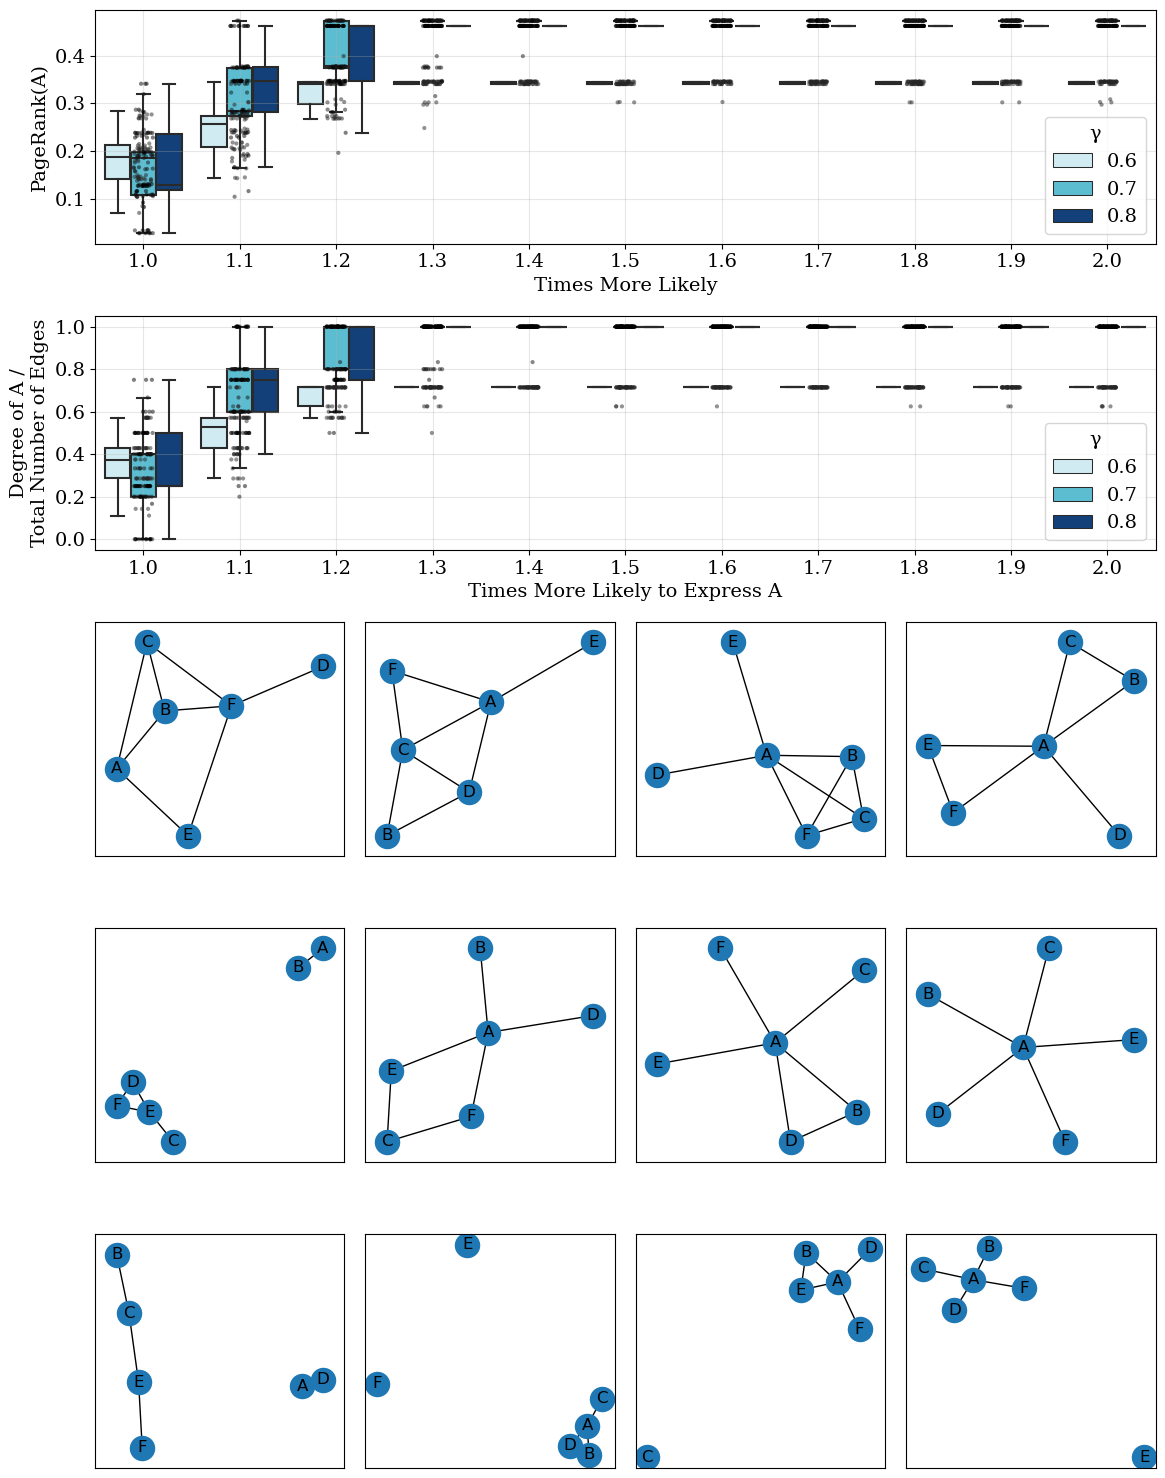

In [49]:
gs = gridspec.GridSpec(5, 4,
                        #width_ratios=[1, 10, 10], 
                        #height_ratios=[1, 1, 1],
                        )

fig = plt.figure(figsize=(12, 15))

ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])  # spans all columns, first row
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[2, 1])
ax4 = fig.add_subplot(gs[2, 2])
ax5 = fig.add_subplot(gs[2, 3])

ax6 = fig.add_subplot(gs[3, 0])
ax7 = fig.add_subplot(gs[3, 1])
ax8 = fig.add_subplot(gs[3, 2])
ax9 = fig.add_subplot(gs[3, 3])

ax10 = fig.add_subplot(gs[4, 0])
ax11 = fig.add_subplot(gs[4, 1])
ax12 = fig.add_subplot(gs[4, 2])
ax13 = fig.add_subplot(gs[4, 3])


sns.boxplot(edge_ratio_analysis[edge_ratio_analysis['γ']!=0], 
            hue='γ', 
            x='Times More Likely',
            y = 'PageRank',
            palette=['#caf0f8', '#48cae4', '#023e8a'],
            ax=ax0,
            showfliers=False)

sns.stripplot(edge_ratio_analysis[edge_ratio_analysis['γ']!=0], 
            hue='γ', 
            x='Times More Likely',
            y = 'PageRank',
            legend=False,
            ax=ax0,
            color='black',
            size=3,
            alpha=.5)
ax0.grid(alpha=.3)
ax0.set_ylabel('PageRank(A)')


sns.boxplot(edge_ratio_analysis[edge_ratio_analysis['γ']!=0], 
            hue='γ', 
            x='Times More Likely',
            y = 'Degree of A / Total Number of Edges',
            palette=['#caf0f8', '#48cae4', '#023e8a'],
            ax=ax1,
            showfliers=False)

sns.stripplot(edge_ratio_analysis[edge_ratio_analysis['γ']!=0], 
            hue='γ', 
            x='Times More Likely',
            y = 'Degree of A / Total Number of Edges',
            legend=False,
            ax=ax1,
            color='black',
            size=3,
            alpha=.5)

ax1.set_xlabel('Times More Likely to Express A')
ax1.set_ylabel('Degree of A /\nTotal Number of Edges')
ax1.grid(alpha=.3)
#ax1.legend(frameon=False)


gamma_vals = [.6,.7,.8]
times_more_likely_vals = [1,1.1,1.2,1.5]

list_of_axs = [ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13]
indexer = 0
gamma_vals = [.6,.7,.8]
times_more_likely_vals = [1, 1.1, 1.2, 1.5]
params = [*itertools.product(gamma_vals, times_more_likely_vals)]

for gamma, times_more_likely in params:
    #values = np.array([track[gamma][times_more_likely][s][last_time_step]['degree'] / 
    #                    track[gamma][times_more_likely][s][last_time_step]['edge_count']
    #                    for s in [*range(repetition)]])
    #mode_val = stats.mode(values).mode
    #representative_sim_no = np.where(values==mode_val)[0][0]

    values = np.array([track[gamma][times_more_likely][s][last_time_step]['pagerank']['A'] for s in [*range(repetition)]])
    representative_sim_no = np.argmin([abs(np.mean(values)-v) for v in values])

    rel = track[gamma][times_more_likely][representative_sim_no][last_time_step]['relationships']
    g = network_out_of_relationships(rel)
    nx.draw_networkx(g, ax = list_of_axs[indexer])
    indexer += 1

fig.tight_layout()

fig.savefig('../figures/centrality_of_A.pdf')